# Data exploration on Airbnb data

*** An assignment interview at Boonmee lab ***


## 1. Import package and loading data

In [1]:
#import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget
import folium
%matplotlib inline

In [2]:
# Set color palette
colors= ['#ED2E7C', '#474056', '#8d99ae', '#F5A3AF', '#F8B4C8', '#F4C095', '#679289', '#1D7874', '#071E22']
sns.set_palette(sns.color_palette(colors))

#Create pie chart function
def pie_chart(data, labels, label_name, title):
        fig, ax = plt.subplots(figsize=(10,5))
        wedges, texts, autotexts = ax.pie(data, autopct='%1.1f%%', colors=colors)
        ax.legend(wedges, labels,
                title=label_name,
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))
        ax.set_title(title)
        for autotext in autotexts:
                autotext.set_color('white')

#Create bar chart function
def barh_chart(x, y, title):
        fig, ax = plt.subplots(figsize=(10,5))
        chart = ax.barh(x, y)
        ax.set_title(title)

        def autolabel(chart):
                for c in chart:
                        width = round(c.get_width(),1)
                        ax.annotate('{}'.format(width),
                                xy=(c.get_x() + width, c.get_y() + c.get_height()/2),
                                xytext=(3, 0),  
                                textcoords="offset points",
                                ha='left', va='center')

        autolabel(chart)
        return ax

In [3]:
#Read csv file
filename = "Workshop - Airbnb - AirBnB_NYC.csv"
bnb = pd.read_csv(filename)

## 2. Cleaning data

### 2.1) เปลี่ยนชื่อ column

- ให้มีแต่ lowercase
- ลบช่องว่างหน้า-หลัง

In [4]:
col_name = bnb.columns.tolist()

for i in range(len(col_name)):
    col_name[i] = col_name[i].strip().lower()

bnb.columns = col_name

In [5]:
bnb.columns.tolist()

['host id',
 'host since',
 'name',
 'neighbourhood',
 'property type',
 'room type',
 'zipcode',
 'beds',
 'review scores rating',
 'review scores rating (bin)',
 'price',
 'number of records',
 'number of reviews']

### 2.2) ลบ column ที่ไม่ใช้

In [6]:
bnb.drop('number of records', axis=1, inplace=True)

### 2.3) เปลี่ยน data type ให้เหมาะสม

In [7]:
#ดูลักษณะของะ data type ของข้อมูลคร่าวๆ ในแต่ละ column
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   host id                     30478 non-null  int64  
 1   host since                  30475 non-null  object 
 2   name                        30478 non-null  object 
 3   neighbourhood               30478 non-null  object 
 4   property type               30475 non-null  object 
 5   room type                   30478 non-null  object 
 6   zipcode                     30344 non-null  float64
 7   beds                        30393 non-null  float64
 8   review scores rating        22155 non-null  float64
 9   review scores rating (bin)  22155 non-null  float64
 10  price                       30478 non-null  object 
 11  number of reviews           30478 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 2.8+ MB


พบว่าบาง column มี data type ที่ไม่เหมาะสม ทำให้ไม่สามารถนำไปวิเคราะห์ต่อได้ ฉะนั้นจะต้องเปลี่ยน data type ก่อน ประกอบด้วย
- column "host id" เปลี่ยนจาก int เป็น string
- column "host since" เปลี่ยนจาก string (object) เป็น datetime
- column "zipcode" เปลี่ยนจาก float เป็น string
- column "price" เปลี่ยนจาก string เป็น float



In [8]:
#เปลี่ยน data type ให้เหมาะสม

#column "Host Id" เปลี่ยนจาก int เป็น string
bnb['host id'] = bnb['host id'].astype('str')
#column "Host Since" เปลี่ยนจาก string (object) เป็น datetime
bnb['host since'] = pd.to_datetime(bnb['host since'])
#column "Zipcode" เปลี่ยนจาก float เป็น string
bnb['zipcode'] = bnb['zipcode'].fillna(-1).astype('int').astype('str')
#column "Price" เปลี่ยนจาก string เป็น float
bnb['price'] = bnb['price'].str.replace(',', '').astype('float')

#ดูลักษณะของะ data type ที่เปลี่ยนไป
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   host id                     30478 non-null  object        
 1   host since                  30475 non-null  datetime64[ns]
 2   name                        30478 non-null  object        
 3   neighbourhood               30478 non-null  object        
 4   property type               30475 non-null  object        
 5   room type                   30478 non-null  object        
 6   zipcode                     30478 non-null  object        
 7   beds                        30393 non-null  float64       
 8   review scores rating        22155 non-null  float64       
 9   review scores rating (bin)  22155 non-null  float64       
 10  price                       30478 non-null  float64       
 11  number of reviews           30478 non-null  int64     

### 2.4) จัดการกับข้อมูลที่ซ้ำกัน (duplicate)

พบว่ามีข้อมูลบางรายการที่ซ้ำกัน โดยพิจารณาจาก column 'Host Id', 'Name', 'Neighbourhood ', 'Property Type', 'Room Type', 'Zipcode', และ 'Beds' มีค่าที่เหมือนกัน แสดงว่าเป็นห้องพักเดียวกัน

In [9]:
dup_subset = ['host id', 'name', 'neighbourhood', 'property type', 'room type', 'zipcode', 'beds']
count_dup = len(bnb[bnb.duplicated(subset=dup_subset, keep='last')])
print(f'พบข้อมูลที่ซ้ำกันทั้งหมด {count_dup!s} รายการ')

พบข้อมูลที่ซ้ำกันทั้งหมด 123 รายการ


นอกจากนี้ พบอีกว่าค่าที่ซ้ำกันเกิดขึ้นได้ 2 กรณี

1) ข้อมูลซ้ำกันในทุก column 

2) ข้อมูลซ้ำกันเกือบทุก column ยกเว้น "review scores rating", "review scores rating (bin)" และ "number of reviews" ที่มีค่าแตกต่างกัน

สันนิษฐานได้ว่าข้อมูลนี้มีการเก็บข้อมูลเป็น time series ในแต่ละห้องพัก ตามจำนวนรีวิวที่เพิ่มขึ้น

In [10]:
#ยกตัวอย่างข้อมูลห้องพักที่ซ้ำกัน
bnb[(bnb.duplicated(subset=dup_subset, keep=False)) & (bnb['host id'] == '23120620')].sort_values(by=['price', 'number of reviews'])

host id host since                                name neighbourhood  \
27540  23120620 2014-10-29  Beachfront Queen Room at townhouse        Queens   
27541  23120620 2014-10-29  Beachfront Queen Room at townhouse        Queens   
27542  23120620 2014-10-29  Beachfront Queen Room at townhouse        Queens   
27539  23120620 2014-10-29  Affordable luxury room in Flushing        Queens   
26     23120620 2014-10-29  Affordable luxury room in Flushing        Queens   

      property type     room type zipcode  beds  review scores rating  \
27540         House  Private room   11692   1.0                   NaN   
27541         House  Private room   11692   1.0                   NaN   
27542         House  Private room   11692   1.0                   NaN   
27539     Apartment  Private room   11354   1.0                   NaN   
26        Apartment  Private room   11354   1.0                  20.0   

       review scores rating (bin)  price  number of reviews  
27540                         NaN   65.0                  0  
27541                         NaN   65.0                  0  
27542                         NaN   65.0                  0  
27539                         NaN   88.0                  0  
26                           20.0   88.0                  2

ดังนั้น จึงจัดการข้อมูลที่ซ้ำกันโดยเลือกข้อมูลใน column "number of reviews" มากที่สุด แสดงถึงข้อมูลที่ล่าสุดกว่า

In [11]:
#sort value
bnb = bnb.sort_values(by=['host id', 'name', 'neighbourhood', 'property type', 'zipcode', 'beds', 'number of reviews']).reset_index(drop=True)
#ลบค่าซ้ำ โดยเลือกค่าสุดท้าย หรือ 'number of reviews' มากที่สุด
bnb = bnb.drop_duplicates(subset=dup_subset, keep='last').reset_index(drop=True)

In [12]:
#Check again
count_dup = len(bnb[bnb.duplicated(subset=dup_subset, keep='last')])
print(f'พบข้อมูลที่ซ้ำกันทั้งหมด {count_dup!s} รายการ')

พบข้อมูลที่ซ้ำกันทั้งหมด 0 รายการ


### 2.5) จัดการกับค่าที่หายไป (missing values)

column ที่ยังมี missing value อีก ได้แก่
- "host since" (ไม่ต้องจัดการ)
- "property type" (2.5.1)
- "beds" (2.5.2)
- "review scores rating" (2.5.3)

In [13]:
#ดูจำนวนช่องว่าง (N/A) ในแต่ละ column
bnb.isnull().sum()

host id                          0
host since                       3
name                             0
neighbourhood                    0
property type                    3
room type                        0
zipcode                          0
beds                            85
review scores rating          8279
review scores rating (bin)    8279
price                            0
number of reviews                0
dtype: int64

** 2.5.1) จัดการ missing value ใน column "property type" **

เนื่องจากไม่ทราบประเภทอสังหาฯ จึงจัดให้ไปอยู่ในหมวด Other

In [14]:
#ให้ค่า NaN == 'Other'
bnb['property type'].fillna('Other', inplace=True)

** 2.5.2) จัดการ missing value ใน column "beds" **

พบว่ามีทั้งหมด 85 รายการที่ไม่มีค่า (NaN) 

ซึ่งแก้ไขโดยใช้ค่า Median ของ column "beds" ซึ่งเท่ากับ 1 มาใส่แทน
แต่ไม่รวมถึง ค่า "price" ที่เป็น outliner (> 95 percentile) จะถูกคัดทิ้ง

In [15]:
#ค่าสถิติของราคา ในรายการที่ "beds" == NaN
bnb[bnb['beds'].isnull()]['price'].describe()

count      85.000000
mean      211.552941
std       372.808533
min        40.000000
25%        80.000000
50%       123.000000
75%       180.000000
max      3000.000000
Name: price, dtype: float64

In [16]:
#ให้รายการที่ไม่มีค่า ใช้ค่า Median ของ Beds ซึ่งเท่ากับ 1 มาใส่แทน แต่ไม่รวมถึงรายการที่ Price เป็น outliner
bnb['beds'] = np.where((bnb['beds'].isnull()) & (bnb['price'] < bnb[bnb['beds'].isnull()]['price'].quantile(0.95)), bnb['beds'].median(), bnb['beds'])

#เนื่องจากบางรายการใน outliner ได้บอกจำนวนห้องนอนใน column "Name"
bnb.iloc[[6481, 12285], 7] = 1
bnb.iloc[13380, 7] = 3

bnb[(bnb['beds'].isnull())]

host id host since                               name neighbourhood  \
13439  2571928 2012-06-07  Gorgeous breath taking river view     Manhattan   
22016  4231575 2012-11-24     boerum hill, downtown brooklyn      Brooklyn   
26477  6804007 2013-06-08             Monoambiente en el UES     Manhattan   

      property type        room type zipcode  beds  review scores rating  \
13439     Apartment     Private room   10016   NaN                   NaN   
22016     Apartment  Entire home/apt   11217   NaN                   NaN   
26477     Apartment  Entire home/apt   10028   NaN                 100.0   

       review scores rating (bin)   price  number of reviews  
13439                         NaN  1700.0                  0  
22016                         NaN   500.0                  0  
26477                       100.0   650.0                  3

In [17]:
#จากนั้น drop รายการที่เหลือทิ้ง
bnb.drop(bnb[(bnb['beds'].isnull())].index, inplace=True)

#ให้ค่าที่น้อยกว่า 1 (=0) ให้มีค่าเท่ากับ median หรือ 1
bnb['beds'] = np.where(bnb['beds'] < 1, bnb['beds'].median(), bnb['beds'])

In [18]:
#สร้าง column "price_per_bed" แสดงราคาต่อเตียงแต่ละห้องพัก
bnb['price_per_bed'] = bnb['price'] / bnb['beds']

** 2.5.3) จัดการ missing value ใน column "review scores rating" **

พบว่า column "review scores rating" ไม่มีค่า เป็นไปได้ 2 กรณี

1) ที่พักแห่งนั้นไม่มีลูกค้ารีวิว แสดงได้จาก column 'number of reviews' = 0 -> กรณีนี้ไม่ต้องแก้ไขใดๆ

2) ที่พักแห่งนั้นมีลูกค้ารีวิว แต่ข้อมูลหายไป แสดงได้จาก column 'number of reviews' > 0 -> เนื่องจากไม่ทราบค่ารีวิวที่แท้จริงจึงถือว่าที่แห่งนี้ไม่มีรีวิว

In [19]:
#ตรวจสอบ 'number of reviews' ในรายการที่ 'review scores rating' == NaN
bnb[bnb['review scores rating'].isnull()]['number of reviews'].value_counts()

0     7769
1      439
2       49
3       12
4        3
5        2
6        1
18       1
9        1
Name: number of reviews, dtype: int64

In [20]:
#ให้ column 'number of reviews' = 0 ในกรณีที่ 2
bnb['number of reviews'] = np.where((bnb['review scores rating'].isnull()) & (bnb['number of reviews'] > 0), 0, bnb['number of reviews'])

In [21]:
#ดูจำนวนช่องว่าง (NaN) ในแต่ละ column อีกครั้ง
bnb.isnull().sum()

host id                          0
host since                       3
name                             0
neighbourhood                    0
property type                    0
room type                        0
zipcode                          0
beds                             0
review scores rating          8277
review scores rating (bin)    8277
price                            0
number of reviews                0
price_per_bed                    0
dtype: int64

### 2.6) สร้างกลุ่มราคาต่อเตียง

แบ่งกลุ่มราคาห้องพักต่อเตียงออกเป็น 3 กลุ่มเท่าๆ กัน (low/middle/high)

In [22]:
price_segment = ['low', 'middle', 'high']
bnb['price_bin'] = pd.qcut(bnb['price_per_bed'], labels = price_segment, q = 3)

## 3) Exploring Data

### Fact 1: ห้องพักในนิวยอร์กส่วนใหญ่กระจุกตัวอยู่ในเขตแมนฮัตตันและบรูคลิน

ห้องพักในนิวยอร์กส่วนใหญ่กระจุกตัวอยู่ในเขตแมนฮัตตัน (Manhattan) และเขตบรูคลิน (Brooklyn)  ซึ่งมีจำนวนห้องพัก Airbnb รวมสองเขตคิดเป็น 91% ของจำนวนห้องพักทั้งหมด


In [23]:
#พบว่าข้อมูลนี้เป็นข้อมูลห้องพักใน New york city ซึ่งแบ่งออกเป็น 5 เขต
bnb['neighbourhood'].unique().tolist()

['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']

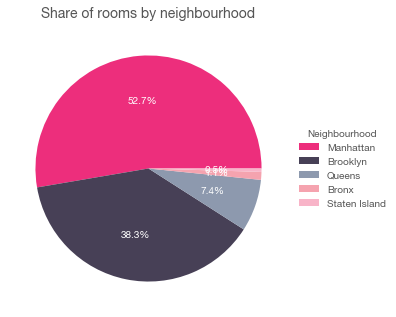

In [24]:
#สัดส่วนจำนวนห้องพักในแต่ละเขต
nbh_share = bnb['neighbourhood'].value_counts(normalize=True)
nbh_label = bnb['neighbourhood'].value_counts(normalize=True).index.tolist()

pie_chart(nbh_share, nbh_label, "Neighbourhood", "Share of rooms by neighbourhood")

In [25]:
#แสดงจำนวนห้องพักในแต่ละเขตในรูปแบบแผนที่ 
url_neighbourhood = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/new-york-city-boroughs.geojson'
wget.download(url_neighbourhood)

neighbourhood_geo = 'new-york-city-boroughs.geojson'

neighbourhood_count = bnb['neighbourhood'].value_counts().reset_index().rename(columns={'index':'neighbourhood','neighbourhood':'count'})

map = folium.Map(location=[40.693943, -73.985880],tiles='Mapbox Bright', zoom_start=10)
map.choropleth(geo_data=neighbourhood_geo, data=neighbourhood_count, columns=['neighbourhood', 'count'], key_on='feature.properties.name',fill_color='OrRd', legend_name='Count')

map

In [26]:
#แสดงจำนวนห้องพักในแต่ละ zipcode ในรูปแบบแผนที่ 
url_zipcode = 'https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson'
wget.download(url_zipcode)

zipcode_geo = 'nyc-zip-code-tabulation-areas-polygons.geojson'

zipcode_count = bnb['zipcode'].value_counts().reset_index().rename(columns={'index':'zipcode','zipcode':'count'})

map = folium.Map(location=[40.693943, -73.985880],tiles='Mapbox Bright', zoom_start=10)
map.choropleth(geo_data=zipcode_geo, data=zipcode_count, columns=['zipcode', 'count'], key_on='feature.properties.postalCode',fill_color='OrRd', legend_name='Count')

map

### Fact 2: ผู้ให้บริการส่วนใหญ่เป็นรายย่อย

โดยเฉลี่ยในแต่ละเขต ผู้ให้บริการ 1 รายจะมีห้องพักให้บริการเฉลี่ย 1.2-1.5 ห้อง และผู้ให้บริการที่มีห้องพัก 1 ห้องมีสัดส่วนสูงถึง 95.4% แสดงว่าผู้ให้บริการใน Airbnb ส่วนใหญ่เป็นรายย่อย ขณะที่ผู้ให้บริการที่มีจำนวนห้องสูงสุดอยู่ที่ 32 ห้องในเขตควีน (Queen)


In [27]:
#จำนวนห้องพักเฉลี่ยต่อผู้ให้บริการ 1 ราย
host = bnb.groupby(['host id', 'neighbourhood']).count()['name'].reset_index().sort_values(by = ['neighbourhood', 'name'], ascending= True)
host.drop_duplicates(subset='neighbourhood', keep='last').sort_values(by='name', ascending = True)
room_per_host_map = host.groupby('neighbourhood').mean().sort_values(by='name', ascending = False).reset_index().rename(columns={'name':'room per host'})

room_per_host_map 

neighbourhood  room per host
0  Staten Island       1.505155
1          Bronx       1.455319
2         Queens       1.322996
3       Brooklyn       1.248441
4      Manhattan       1.206701

In [28]:
#แสดงจำนวนห้องพักเฉลี่ยต่อผู้ให้บริการ 1 รายในรูปแผนที่
map = folium.Map(location=[40.693943, -73.985880],tiles='Mapbox Bright', zoom_start=10)
map.choropleth(geo_data=neighbourhood_geo, 
                data=room_per_host_map, 
                columns=['neighbourhood', 'room per host'], 
                key_on='feature.properties.name', 
                fill_color='OrRd', 
                legend_name='Average room per host')

from folium.plugins import MarkerCluster
from folium.features import DivIcon

nyc_loc = {'Manhattan': [40.7831, -73.9712],
            'Staten Island': [40.5795, -74.1502],
            'Queens': [40.7282, -73.7949],
            'Brooklyn': [40.6782, -73.9442],
            'Bronx': [40.8448, -73.8648]}

marker_cluster = MarkerCluster().add_to(map)

for i in range(len(room_per_host_map)):
    location = nyc_loc[room_per_host_map.iloc[i, 0]]
    tooltip = "Neighbourhood: {}<br>".format(room_per_host_map.iloc[i, 0])
    number = round(room_per_host_map.iloc[i, 1], 1)
    folium.Marker(location,tooltip=tooltip,
        icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html='<div style="font-family: Helvetica Neue; font-size: 12pt; color : black">{}</div>'.format(number),
        )).add_to(marker_cluster)

map

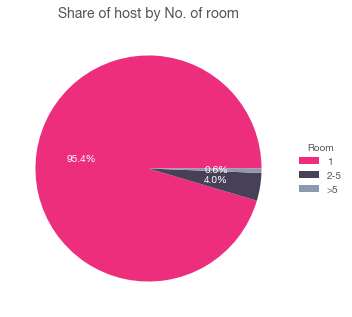

In [29]:
#สัดส่วนจำนวนห้องพักของผู้ให้บริการ
room_byhost_share =  pd.cut(host['name'],[0, 2, 5, np.inf], labels=['1', '2-5', '>5']).value_counts(normalize=True)
pie_chart(room_byhost_share, ['1', '2-5', '>5'], "Room", "Share of host by No. of room")

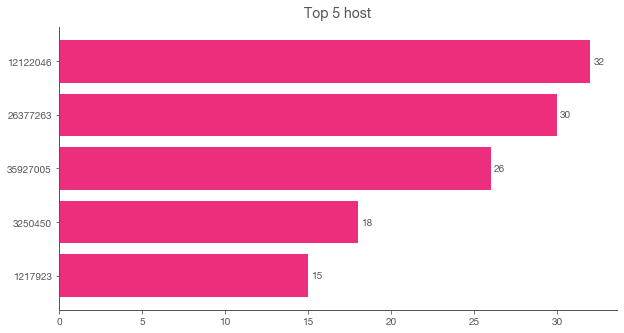

In [30]:
#ผู้ให้บริการที่มีจำนวนห้องพักสูงสุด 5 อันดับ
top_host = bnb.groupby('host id').count()['name'].sort_values(ascending=False).head(5).reset_index().sort_values(by='name')
barh_chart(top_host['host id'],top_host['name'], 'Top 5 host')

### Fact 3: ปัจจัยที่มีผลต่อการตั้งราคาห้องพัก

** 1) ทำเลที่ตั้งของห้องพัก **

ห้องพักในเขตแมนฮัตตัน (Manhattan) มีโอกาสตั้งราคาห้องพักต่อเตียงได้สูงกว่า เนื่องจากมีสัดส่วนจำนวนห้องพักราคาสูงมากเทียบกับราคาปานกลางและต่ำ


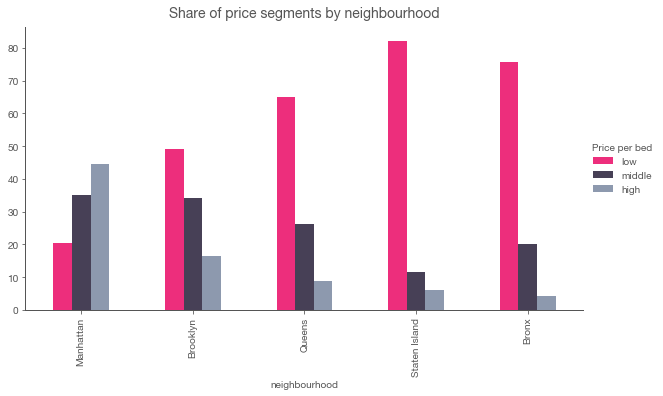

In [31]:
price_seg = bnb.groupby(['neighbourhood', 'price_bin']).count()['name'].reset_index()
price_seg_pv = pd.pivot_table(price_seg, index='neighbourhood', columns='price_bin', values='name')
price_seg_pv = price_seg_pv.div(price_seg_pv.sum(axis=1), axis=0).sort_values(by='high', ascending=False)

#สัดส่วนห้องพักแบ่งตามกลุ่มราคา
ax = (price_seg_pv * 100).plot.bar(figsize=(10,5))
ax.set_title("Share of price segments by neighbourhood")
ax.legend(title="Price per bed", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

** 2) ประเภทห้องพัก **

ห้องพักประเภท Entire home/apt มีโอกาสตั้งราคาได้สูงที่สุด เนื่องจากมีค่าเฉลี่ยราคาต่อเตียงมากกว่า Private room และ Shared room ตามลำดับ

[(0, 500), Text(0, 0.5, 'Price per bed')]

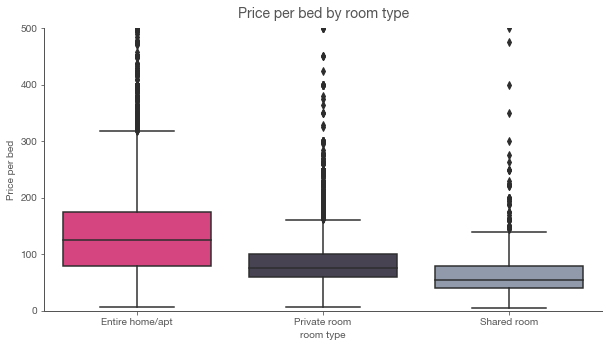

In [32]:
#การกระจายตัวของราคาต่อเตียง แบ่งตามประเภทห้องพัก
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(x='room type', y='price_per_bed', data=bnb)
ax.set_title('Price per bed by room type', y=1)
ax.set(ylim=(0, 500), ylabel='Price per bed')

** 3) คะแนนรีวิว **

คะแนนรีวิวที่สูง มีความสัมพันธ์กับราคาที่สูงขึ้น ดังนั้น ถ้ามีคะแนนรีวิวห้องพักสูงจะมีโอกาสตั้งราคาได้สูงขึ้น


Text(0.5, 1.1, 'Price per bed and review scores rating')

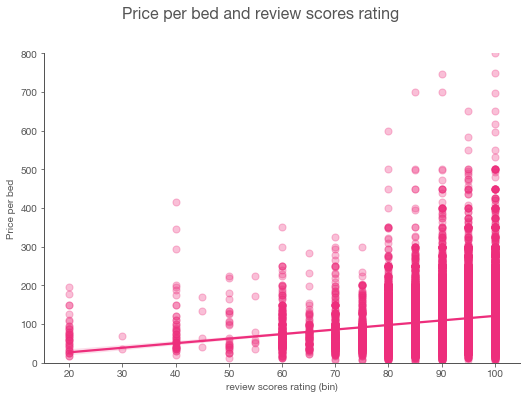

In [33]:
#ราคาต่อเตียงและคะแนนรีวิว
review_vs_price = bnb[['price_per_bed', 'review scores rating (bin)']]
ax = sns.lmplot(x='review scores rating (bin)', y='price_per_bed', data=review_vs_price, scatter_kws={"s": 50, "alpha": 0.3}, height=5, aspect=1.5)
ax.set(ylim=(0, 800), ylabel='Price per bed')
ax.fig.suptitle("Price per bed and review scores rating", y=1.1)